---
layout: post
title:  "시계열수치입력 수치예측 모델 레시피"
author: 김태영
date:   2017-09-09 01:10:00
categories: Lecture
comments: true
image: http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_4m.png
---

시계열 수치를 입력해서 다음 수치를 예측하는 모델들에 대해서 알아보겠습니다. 각 모델에 코사인(cos) 데이터를 학습시킨 후, 처음 일부 데이터를 알려주면 이후 코사인 형태의 데이터 예측을 얼마나 잘 하는 지 테스트 하겠습니다.

---
### 데이터셋 준비

먼저 코사인 데이터를 만들어보겠습니다. 시간의 흐름에 따라 진폭이 -1.0에서 1.0사이로 변하는 1,000개의 실수값을 생성합니다.

In [1]:
import numpy as np

signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

생성한 데이터를 확인해보겠습니다.

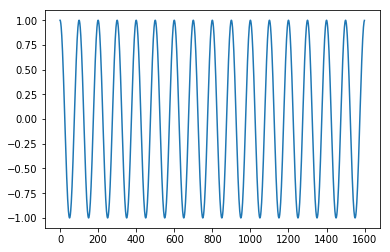

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

생성한 코사인 데이터를 모델에 학습시키기 위해서는 데이터와 라벨로 구성된 데이터셋으로 만들어야 합니다. 이전 수치들을 입력하여 다음 수치를 예측하는 문제이므로 데이터는 이전 수치들이 되고, 라벨은 다음 수치가 됩니다. 다른 예제들과는 달리 데이터와 라벨이 모두 같은 속성입니다. 아래 create_dataset() 함수는 시계열 수치를 입력받아 데이터셋을 생성합니다. 이 때 look_back 인자는 얼마만큼의 이전 수치를 데이터로 만들것인가를 결정합니다.

In [3]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

-1.0에서 1.0까지의 값을 가지는 코사인 데이터를 0.0과 1.0 사이의 값을 가지도록 정규화를 한 뒤 훈련셋과 시험셋으로 분리합니다. 이전 20개의 수치를 입력하여 다음 수치 1개를 예측하는 데이터셋을 만들기 위해 look_back 인자를 20으로 설정하였습니다.

In [4]:
from sklearn.preprocessing import MinMaxScaler

look_back = 40

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

---
### 레이어 준비

본 장에서 새롭게 소개되는 블록들은 다음과 같습니다.

|블록|이름|설명|
|:-:|:-:|:-|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_LSTM_s.png)|LSTM|Long-Short Term Memory unit의 약자로 순환 신경망 레이어 중 하나입니다.|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Activation_hard_sigmoid_s.png)|hard_sigmoid|LSTM의 출력 활성화 함수로 주로 사용됩니다.|

(http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_LSTM_Example.png)

---
### 모델 준비

수치예측을 하기 위해 `선형회귀 모델`, `퍼셉트론 모델`, `다층퍼셉트론 모델`, `깊은 다층퍼셉트론 모델`을 준비했습니다.

MLP

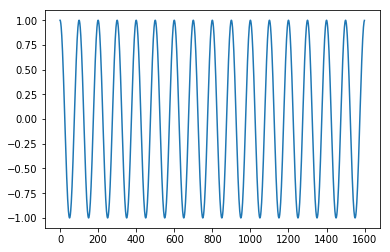

Train on 760 samples, validate on 360 samples
Epoch 1/100
760/760 [==============================] - 0s - loss: 0.1081 - val_loss: 0.0163
Epoch 2/100
760/760 [==============================] - 0s - loss: 0.0439 - val_loss: 0.0093
Epoch 3/100
760/760 [==============================] - 0s - loss: 0.0393 - val_loss: 0.0158
Epoch 4/100
760/760 [==============================] - 0s - loss: 0.0344 - val_loss: 0.0175
Epoch 5/100
760/760 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0115
Epoch 6/100
760/760 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0182
Epoch 7/100
760/760 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0174
Epoch 8/100
760/760 [==============================] - 0s - loss: 0.0241 - val_loss: 0.0179
Epoch 9/100
760/760 [==============================] - 0s - loss: 0.0220 - val_loss: 0.0124
Epoch 10/100
760/760 [==============================] - 0s - loss: 0.0225 - val_loss: 0.0230
Epoch 11/100
760/760 [===========

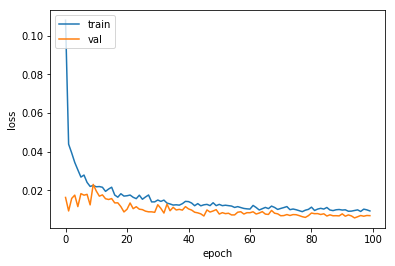

('Train Score: ', 0.0067915841839031165)
('Validataion Score: ', 0.0068324710138969952)
('Test Score: ', 0.0068324710138969952)


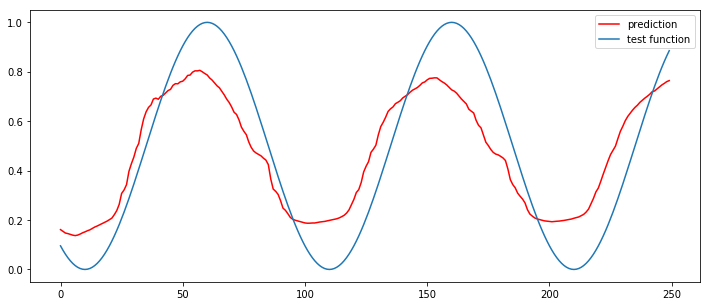

In [18]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train = np.squeeze(x_train)
x_val = np.squeeze(x_val)
x_test = np.squeeze(x_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(32,input_dim=40,activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adagrad')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
#plt.ylim(0.0, 300.0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
          
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0, None]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

LSTM

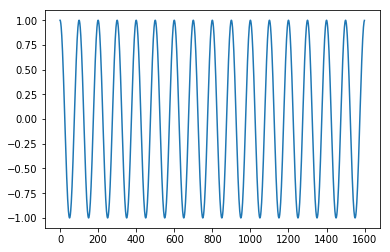

Train on 760 samples, validate on 360 samples
Epoch 1/100
760/760 [==============================] - 0s - loss: 0.1641 - val_loss: 0.0448
Epoch 2/100
760/760 [==============================] - 0s - loss: 0.0419 - val_loss: 0.0231
Epoch 3/100
760/760 [==============================] - 0s - loss: 0.0262 - val_loss: 0.0107
Epoch 4/100
760/760 [==============================] - 0s - loss: 0.0143 - val_loss: 0.0026
Epoch 5/100
760/760 [==============================] - 0s - loss: 0.0096 - val_loss: 0.0011
Epoch 6/100
760/760 [==============================] - 0s - loss: 0.0081 - val_loss: 7.8521e-04
Epoch 7/100
760/760 [==============================] - 0s - loss: 0.0074 - val_loss: 8.3471e-04
Epoch 8/100
760/760 [==============================] - 0s - loss: 0.0079 - val_loss: 0.0016
Epoch 9/100
760/760 [==============================] - 0s - loss: 0.0070 - val_loss: 6.1584e-04
Epoch 10/100
760/760 [==============================] - 0s - loss: 0.0058 - val_loss: 5.2903e-04
Epoch 11/100
760/

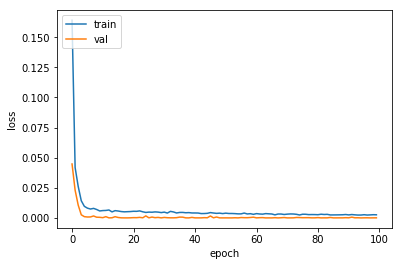

('Train Score: ', 9.115958880437048e-05)
('Validataion Score: ', 9.2583661898970601e-05)
('Test Score: ', 9.2583661898970601e-05)


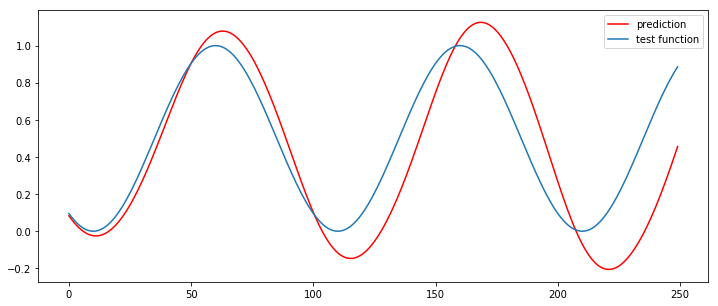

In [3]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
#plt.ylim(0.0, 300.0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=batch_size)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

Stateful LSTM

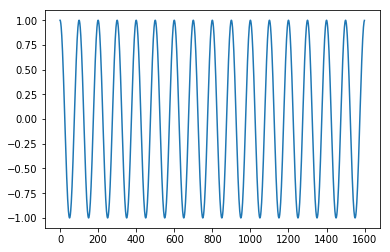

Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 0.0368 - val_loss: 0.0100
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 0.0072 - val_loss: 0.0019
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 0.0056 - val_loss: 7.3141e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 0.0045 - val_loss: 0.0029
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 0.0049 - val_loss: 0.0026
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 0.0043 - val_loss: 0.0016
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 2s - loss: 0.0036 - val_loss: 8.9426e-04
Train on 760 samples, validate on 360 sa

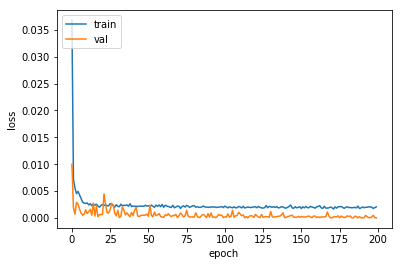

('Train Score: ', 2.7563425735522313e-05)
('Validataion Score: ', 2.7927434640573345e-05)
('Test Score: ', 2.7927448315718312e-05)


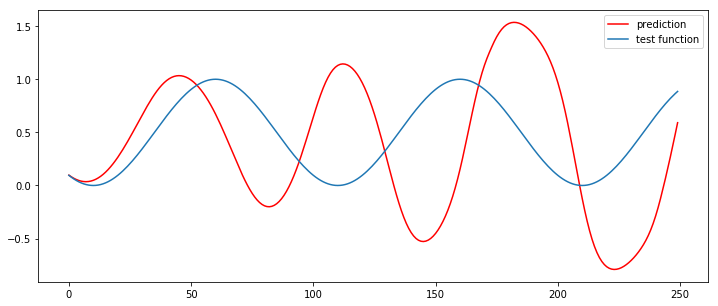

In [2]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
#plt.ylim(0.0, 300.0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

Stateful Statck LSTM

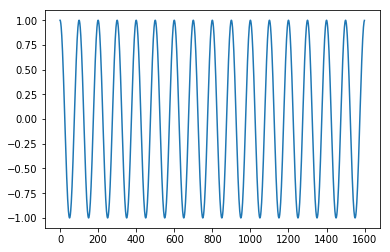

Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s - loss: 0.0795 - val_loss: 0.0621
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s - loss: 0.0323 - val_loss: 0.1642
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s - loss: 0.0624 - val_loss: 0.0121
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s - loss: 0.0126 - val_loss: 0.0165
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s - loss: 0.0133 - val_loss: 0.0152
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s - loss: 0.0111 - val_loss: 0.0081
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 7s - loss: 0.0088 - val_loss: 0.0154
Train on 760 samples, validate on 360 samples
Ep

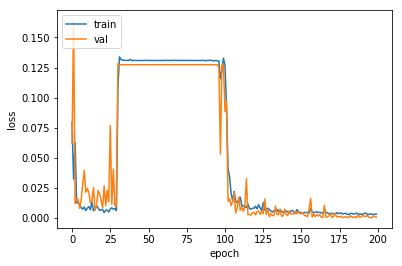

('Train Score: ', 0.00080418380600179556)
('Validataion Score: ', 0.00076996903029728813)
('Test Score: ', 0.00076996910020711421)


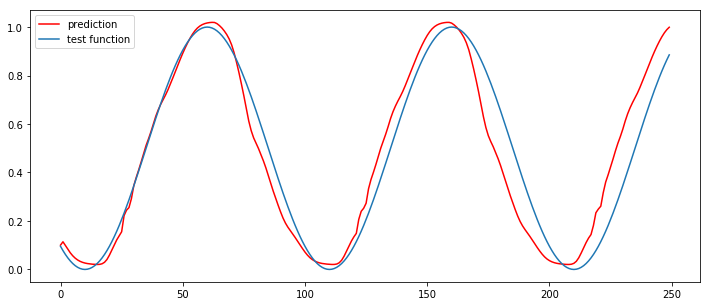

In [5]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
#plt.ylim(0.0, 300.0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

---
### 모델 준비

수치예측을 하기 위해 `선형회귀 모델`, `퍼셉트론 모델`, `다층퍼셉트론 모델`, `깊은 다층퍼셉트론 모델`을 준비했습니다.

#### 선형회귀 모델

가장 간단한 1차 선형회귀 모델로 수치예측을 해보겠습니다. 아래 식에서 x, y는 우리가 만든 데이터셋이고, 회귀분석을 통해서, w와 b값을 구하는 것이 목표입니다. 

    Y = w * X + b
   
w와 b값을 구하게 되면, 임의의 입력 x에 대해서 출력 y가 나오는 데 이것이 예측 값입니다. w, b 값은 분산, 공분산, 평균을 이용하여 쉽게 구할 수 있습니다. 

    w = np.cov(X, Y, bias=1)[0,1] / np.var(X)
    b = np.average(Y) - w * np.average(X)
    
간단한 수식이지만 이 수식을 도출하기란 꽤나 복잡습니다. 오차를 최소화하는 극대값을 구하기 위해 편미분을 수행하고, 다시 식을 전개하는 등등의 과정이 필요합니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_0.png)    

#### 퍼셉트론 모델

Dense 레이어가 하나이고, 뉴런의 수도 하나인 가장 기본적인 퍼셉트론 모델입니다. 즉 웨이트(w) 하나, 바이어스(b) 하나로 전형적인 Y = w * X + b를 풀기 위한 모델입니다. 수치 예측을 하기 위해서 출력 레이어에 별도의 활성화 함수를 사용하지 않았습니다. w, b 값이 손으로 푼 선형회귀 최적해에 근접하려면 경우에 따라 만번이상의 에포크가 필요합니다. 실제로 사용하지는 않는 모델이지만 선형회귀부터 공부하시는 분들에게는 입문 모델로 나쁘지 않습니다.

    model = Sequential()
    model.add(Dense(1, input_dim=1))
        
![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_1m.png)

#### 다층퍼셉트론 모델

Dense 레이어가 두 개인 다층퍼셉트론 모델입니다. 첫 번째 레이어는 64개의 뉴런을 가진 Dense 레이어이고 오류역전파가 용이한 `relu` 활성화 함수를 사용하였습니다. 출력 레이어인 두 번째 레이어는 하나의 수치값을 예측을 하기 위해서 1개의 뉴런을 가지며, 별도의 활성화 함수를 사용하지 않았습니다.

    model = Sequential()
    model.add(Dense(64, input_dim=1, activation='relu'))
    model.add(Dense(1))

![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_2m.png)

#### 깊은 다층퍼셉트론 모델

Dense 레이어가 총 세 개인 다층퍼셉트론 모델입니다. 첫 번째, 두 번째 레이어는 64개의 뉴런을 가진 Dense 레이어이고 오류역전파가 용이한 `relu` 활성화 함수를 사용하였습니다. 출력 레이어인 세 번째 레이어는 하나의 수치값을 예측을 하기 위해서 1개의 뉴런을 가지며, 별도의 활성화 함수를 사용하지 않았습니다.

    model = Sequential()
    model.add(Dense(64, input_dim=1, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_3m.png)    

---
### 전체 소스

앞서 살펴본 `선형회귀 모델`, `퍼셉트론 모델`, `다층퍼셉트론 모델`, `깊은 다층퍼셉트론 모델`의 전체 소스는 다음과 같습니다. 

#### 선형회귀 모델

In [ ]:
# 선형회귀 모델로 수치예측하기

import numpy as np
from sklearn.metrics import mean_squared_error
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 1))
y_train = x_train * 2 + np.random.random((1000, 1)) / 3.0
x_test = np.random.random((100, 1))
y_test = x_test * 2 + np.random.random((100, 1)) / 3.0

x_train = x_train.reshape(1000,)
y_train = y_train.reshape(1000,)
x_test = x_test.reshape(100,)
y_test = y_test.reshape(100,)

# 2. 모델 구성하기
w = np.cov(x_train, y_train, bias=1)[0,1] / np.var(x_train)
b = np.average(y_train) - w * np.average(x_train)

print w, b

# 3. 모델 평가하기

y_predict = w * x_test + b
mse = mean_squared_error(y_test, y_predict)
print('mse : ' + str(mse))

#### 퍼셉트론 모델

In [ ]:
# 퍼셉트론 모델로 수치예측하기

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 1))
y_train = x_train * 2 + np.random.random((1000, 1)) / 3.0
x_test = np.random.random((100, 1))
y_test = x_test * 2 + np.random.random((100, 1)) / 3.0

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(1, input_dim=1))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='mse')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=50, batch_size=64)
w, b = model.get_weights()
print w, b

# 5. 모델 평가하기
loss = model.evaluate(x_test, y_test, batch_size=32)
print('loss : ' + str(loss))

# 6. 학습과정 확인하기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### 다층퍼셉트론 모델

In [ ]:
# 다층퍼셉트론 모델로 수치예측하기

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 1))
y_train = x_train * 2 + np.random.random((1000, 1)) / 3.0
x_test = np.random.random((100, 1))
y_test = x_test * 2 + np.random.random((100, 1)) / 3.0

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='mse')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=50, batch_size=64)

# 5. 모델 평가하기
loss = model.evaluate(x_test, y_test, batch_size=32)
print('loss : ' + str(loss))

# 6. 학습과정 확인하기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### 깊은 다층퍼셉트론 모델

In [ ]:
# 깊은 다층퍼셉트론 모델로 수치예측하기

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 1))
y_train = x_train * 2 + np.random.random((1000, 1)) / 3.0
x_test = np.random.random((100, 1))
y_test = x_test * 2 + np.random.random((100, 1)) / 3.0

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='mse')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=50, batch_size=64)

# 5. 모델 평가하기
loss = model.evaluate(x_test, y_test, batch_size=32)
print('loss : ' + str(loss))

# 6. 학습과정 확인하기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

---

### 학습결과 비교

퍼셉트론 > 다층퍼셉트론 > 깊은 다층퍼셉트론 순으로 학습이 좀 더 빨리 되는 것을 확인할 수 있습니다.

|퍼셉트론|다층퍼셉트론|깊은 다층퍼셉트론|
|:-:|:-:|:-:|
|![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_6.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_7.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_8.png)|

---

### 결론

수치예측을 위한 퍼셉트론, 다층퍼셉트론, 깊은 다층퍼셉트론 모델을 살펴보고, 그 성능을 확인 해봤습니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_4m.png)

본 장은 https://github.com/sachinruk/PyData_Keras_Talk 의 예제를 기반으로 작성되었으며, 예제 코드 사용을 흔쾌히 허락해주신 데이터사이언티스트 Sachin Abeywardana 박사님 감사드립니다.

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)